In [55]:
import numpy as np


def normalize_band(band):
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)
    if band_max - band_min == 0:
        normalized_band = np.zeros_like(band)
    else:
        # Normalize the data
        normalized_band = (band - band_min) / (band_max - band_min)

    normalized_band = np.where(
        np.isnan(normalized_band),
        np.nan,
        normalized_band.astype(np.float32),
    )

    return normalized_band


def nan_maximum(array1, array2):
    return np.where(
        np.isnan(array1),
        array2,
        np.where(
            np.isnan(array2),
            array1,
            np.maximum(array1, array2),
        ),
    )

In [56]:
import os
import random
from osgeo import gdal

input_file = "/home/snt/projects_lujun/vitCausalSeries/data/source/remote_sensing/Causal_MSI_2020_with_city.tif"
output_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate"
train_folder = f"{output_folder}/output_patches_time_series_with_city/train"
val_folder = f"{output_folder}/output_patches_time_series_with_city/val"
patch_size = 60
max_pooling_windows = 2
dataset = gdal.Open(input_file)
if not dataset:
    raise ValueError(f"无法打开文件 {input_file}")

band_count = dataset.RasterCount
width = dataset.RasterXSize
height = dataset.RasterYSize
geo_transform = dataset.GetGeoTransform()  #
projection = dataset.GetProjection()

os.makedirs(output_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

random.seed(42)

# Generate time band mapping dictionary {"time": [band_index1, band_index2, ..., band_indexn]}
time_band_mapping = {}
for i in range(1, band_count + 1):
    band = dataset.GetRasterBand(i)
    band_name = band.GetDescription() or f"Band_{i}"

    if "_" in band_name:
        time_key = band_name.split("_")[-1]
        if time_key not in time_band_mapping:
            time_band_mapping[time_key] = []
        time_band_mapping[time_key].append((i, band_name))
    else:
        cls_name = (i, band_name)

time_band_mapping = dict(sorted(time_band_mapping.items()))
time_span = len(time_band_mapping)
num_channel_per_time = (band_count - 1) // time_span

patch_index = 0
for y in range(0, height, patch_size):
    for x in range(0, width, patch_size):
        if y + patch_size > height or x + patch_size > width:
            continue

        is_validation = patch_index % 5 == 0
        output_subfolder = val_folder if is_validation else train_folder

        patch_filename = os.path.join(output_subfolder, f"patch_{y}_{x}.tif")

        driver = gdal.GetDriverByName("GTiff")
        patch_dataset = driver.Create(
            patch_filename,
            patch_size,
            patch_size,
            time_span // max_pooling_windows * num_channel_per_time + 1,
            gdal.GDT_Float32,
        )
        idx_total = 1
        for i in range(time_span - 1):
            if i % 2 == 0:
                time_key = list(time_band_mapping.keys())[i]
                time_key_next = list(time_band_mapping.keys())[i + 1]
                band_index_list = time_band_mapping[time_key]
                band_index_list_next = time_band_mapping[time_key_next]

                for j in range(len(band_index_list)):
                    (b_idx, b_name) = band_index_list[j]
                    (b_idx_next, b_idx_name) = band_index_list_next[j]

                    band = dataset.GetRasterBand(b_idx)
                    patch_data = normalize_band(
                        band.ReadAsArray(x, y, patch_size, patch_size)
                    )

                    band_next = dataset.GetRasterBand(b_idx_next)
                    patch_data_next = normalize_band(
                        band_next.ReadAsArray(x, y, patch_size, patch_size)
                    )

                    output_band = patch_dataset.GetRasterBand(idx_total)
                    output_band.WriteArray(nan_maximum(patch_data, patch_data_next))
                    band_description = band.GetDescription()
                    if band_description:
                        output_band.SetDescription(band_description)
                    idx_total += 1

        out_band = patch_dataset.GetRasterBand(idx_total)
        band = dataset.GetRasterBand(cls_name[0])
        band_data = out_band.ReadAsArray()
        out_band.WriteArray(band_data)
        out_band.SetDescription(cls_name[1])

        patch_dataset.FlushCache()
        print(f"已保存时间 {time_key} 的所有波段到文件: {patch_filename}")
        patch_dataset = None
        patch_index += 1

/tmp/ipykernel_3100121/2623356077.py:5: RuntimeWarning: All-NaN slice encountered
  band_min = np.nanmin(band)
/tmp/ipykernel_3100121/2623356077.py:6: RuntimeWarning: All-NaN slice encountered
  band_max = np.nanmax(band)


已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/val/patch_0_0.tif
已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train/patch_0_60.tif
已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train/patch_0_120.tif
已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train/patch_0_180.tif
已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train/patch_0_240.tif
已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/val/patch_0_300.tif
已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train/patch_0_360.tif
已保存时间 10 的所有波段到文件: /home/snt/projects_lujun/vitC

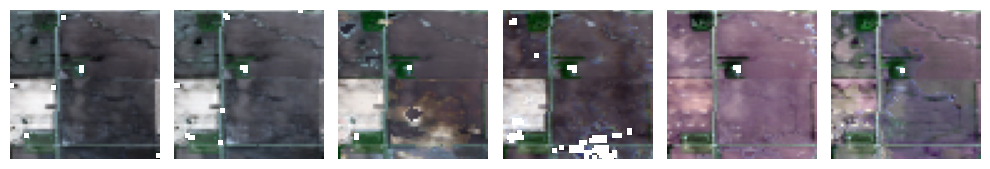

In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal


def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription()
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


tiff = read_tiff(
    "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train/patch_0_60.tif"
)


channel_list = [3, 2, 1]
channels, h, w = tiff.shape
time_span = int((channels) / 11)
images = np.split(tiff, [11 * (i + 1) for i in range(time_span)], axis=0)
time_series_images = []
for i, image in enumerate(images[:-1]):
    image = np.transpose(image, (1, 2, 0))
    pseudo_color_image = image[:, :, channel_list]
    time_series_images.append(pseudo_color_image)

fig, axes = plt.subplots(1, len(time_series_images), figsize=(10, 10))

for j in range(len(time_series_images)):
    axes[j].imshow(time_series_images[j], cmap="gray")  # 修正索引方式
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [58]:
def stitch_patches(patch_folder, patch_size, output_shape, time_span):
    stitched_image = np.zeros(
        (time_span * 11 + 1, output_shape[0], output_shape[1]), dtype=np.float32
    )
    for root, dirs, files in os.walk(patch_folder):
        for patch_file in files:
            if patch_file.endswith(".tif"):
                y, x = map(
                    int, patch_file.replace("patch_", "").replace(".tif", "").split("_")
                )
                patch = read_tiff(os.path.join(root, patch_file))

                stitched_image[:, y : y + patch_size, x : x + patch_size] = patch
    return stitched_image


input_file = "/home/snt/projects_lujun/vitCausalSeries/data/source/remote_sensing/Causal_MSI_2020_with_city.tif"
dataset = gdal.Open(input_file)
if not dataset:
    raise ValueError(f"无法打开文件 {input_file}")

tiff = read_tiff(
    "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train/patch_0_60.tif"
)

channel_list = [3, 2, 1]
channels, h, w = tiff.shape

width = dataset.RasterXSize
height = dataset.RasterYSize

train_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/train"
val_folder = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city/val"

folder_path = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_patches_time_series_with_city"
output_width, output_height = (
    width // patch_size * patch_size,
    height // patch_size * patch_size,
)
time_span = int((channels) / 11)

stitched_train_image = stitch_patches(
    folder_path, patch_size, (output_height, output_width), time_span
)

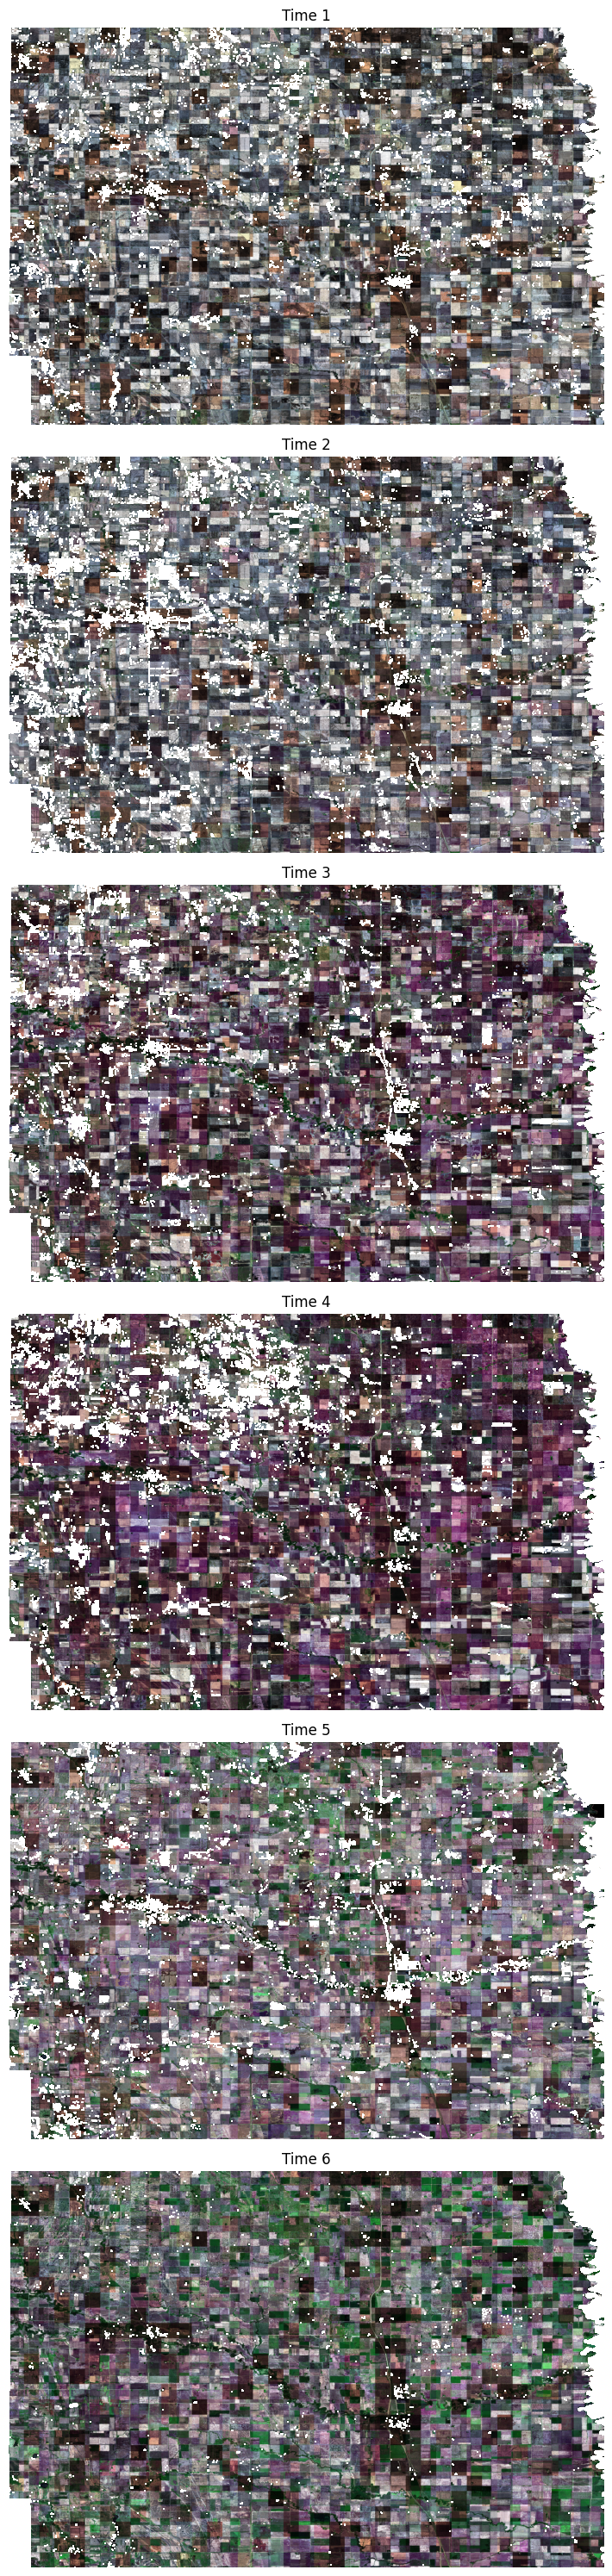

In [59]:
import matplotlib.pyplot as plt


# 可视化函数
def visualize_time_series(image, time_span, channel_list):
    channels, h, w = image.shape
    images = np.split(image, [11 * (i + 1) for i in range(time_span)], axis=0)
    time_series_images = []

    for i, img in enumerate(images[:-1]):
        img = np.transpose(img, (1, 2, 0))  # 调整维度为 (H, W, C)
        pseudo_color_image = img[:, :, channel_list]
        time_series_images.append(pseudo_color_image)

    fig, axes = plt.subplots(
        len(time_series_images), 1, figsize=(10, 30)
    )  # 调整为竖直排列

    for j in range(len(time_series_images)):
        axes[j].imshow(time_series_images[j])  # 显示图像
        axes[j].axis("off")  # 隐藏坐标轴
        axes[j].set_title(f"Time {j+1}")  # 设置标题

    plt.tight_layout()
    plt.show()


# 可视化拼接后的训练集影像
channel_list = [3, 2, 1]  # RGB通道选择
visualize_time_series(stitched_train_image, time_span, channel_list)